In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from shapely.geometry import Point
import matplotlib.pyplot as plt
import rasterio.mask
import fiona
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.warp import reproject, Resampling
from natsort import natsorted
import earthpy.spatial as es
import gdal
from osgeo import osr,gdal_array
import xarray as xr
import netCDF4
import pandas as pd
import numpy as np
import geopandas
import rasterio
import pycrs
import os

file_dir=r'C:/Users/Mark.Rademaker/PycharmProjects/InternshipNaturalis/trait-geo-diverse-dl/data_GIS_extended'

#### Part 1. Stacking Bioclim rasters
- open and stack the raster files

In [3]:
#BIOCLIM dataset
#create list of raster file locations and a list containing only the names of each raster
list_bioclim_files=[]
names_bioclim=[]

for root, dirs, files in os.walk(file_dir+"/data/GIS/wc5"):
    for file in files:
        if file.endswith('.tif') and "stacked" not in file:
            list_bioclim_files.append(file_dir+"/data/GIS/wc5/"+file)
            name=file.replace(".tif","")
            names_bioclim.append(name)
            names_bioclim=natsorted(names_bioclim,key=lambda y: y.lower())
print(names_bioclim)
#Stack BIOCLIM dataset
#es.stack(list_bioclim_files, file_dir+'/data/GIS/env_stacked/BIOCLIM_stacked.tif')

['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19']


#### Part 2. Stacking ENVIREM rasters
- open and stack the raster files

In [4]:
#ENVIREM dataset
#create list of raster file locations and a list containing only the names of each raster
list_envirem_files=[]
names_envirem=[]

for root, dirs, files in os.walk(file_dir+"/data/GIS/5_deg"):
    for file in files:
        if file.endswith('.tif') and "stacked" not in file:
            list_envirem_files.append(file_dir+"/data/GIS/5_deg/"+file)
            name=file.replace(".tif","")
            names_envirem.append(name)
            names_envirem=natsorted(names_envirem,key=lambda y: y.lower())
print(names_envirem)
#Stack ENVIREM dataset
#es.stack(list_envirem_files, file_dir+'/data/GIS/env_stacked/ENVIREM_stacked.tif')

['Aspect_5deg', 'BulkDensity_5min', 'ClayPercentage_5min', 'current_5arcmin_annualPET', 'current_5arcmin_aridityIndexThornthwaite', 'current_5arcmin_climaticMoistureIndex', 'current_5arcmin_continentality', 'current_5arcmin_embergerQ', 'current_5arcmin_growingDegDays0', 'current_5arcmin_growingDegDays5', 'current_5arcmin_maxTempColdest', 'current_5arcmin_minTempWarmest', 'current_5arcmin_monthCountByTemp10', 'current_5arcmin_PETColdestQuarter', 'current_5arcmin_PETDriestQuarter', 'current_5arcmin_PETseasonality', 'current_5arcmin_PETWarmestQuarter', 'current_5arcmin_PETWettestQuarter', 'current_5arcmin_thermicityIndex', 'OrganicCarbon_5min', 'PhCaCL_5min', 'Slope_5deg']


#### Part 3. Create  empty land map to subset new ecobiome and species raster variables on

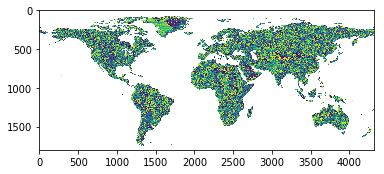

Text(0.5, 1.0, 'land map')

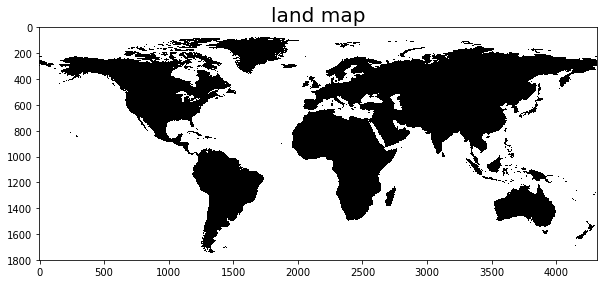

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 4320, 'height': 1800, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [5]:
pred_data=pd.read_csv(file_dir+'/data/GIS/world_locations_to_predict.csv')

long=pred_data["decimal_longitude"]
lati=pred_data["decimal_latitude"]
long=pd.Series.tolist(long)
lati=pd.Series.tolist(lati)

src = rasterio.open(file_dir+'/data/GIS/5_deg/Aspect_5deg.tif')
band= src.read(1,masked=True)
rasterio.plot.show(band)

new_band = band.copy()

#set raster cell mask values of land area to 0 (to differentiate it from the sea)
for i in range(0,len(pred_data)):
    row,col=src.index(long[i],lati[i])
    new_band[row,col]=0

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(new_band,cmap="gray")
ax.set_title("land map",
         fontsize=20)
plt.show()

profile = src.profile
print(profile)

with rasterio.open(file_dir+'/data/GIS/empty_land_map.tif', 'w', **profile) as dst:
        dst.write(new_band.astype(rasterio.float32), 1)

#### Part 4. Create TNC Ecoregion attribute maps
- rasters still in shpfile, must be transformed into raster in right resolution (5deg)

In [6]:
import geopandas as gpd
import rasterio
import fiona
from rasterio import features
import os
from datetime import datetime as dt

In [7]:
#Habitat fragmentation
shp_fn=file_dir+'/data/GIS/tnc/Habitat_Fragmentation/wwf_ecos_hab_frag.shp'
rst_fn =file_dir+'/data/GIS/5_deg/Aspect_5deg.tif'
out_fn =file_dir+'/data/GIS/tnc/ecoregion_attribute_rasters/habitat_fragmentation.tif'

df=gpd.read_file(file_dir+'/data/GIS/tnc/Habitat_Fragmentation/wwf_ecos_hab_frag.shp')

rst = rasterio.open(rst_fn)
meta = rst.meta.copy()


src=rasterio.open(rst_fn)

with rasterio.open(out_fn, 'w', **meta) as out:
    out_arr = src.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(df.geometry, df.fragmntndx))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform,all_touched=True)
    out.write_band(1, burned)

In [8]:
#Human Accessibility
shp_fn=file_dir+'/data/GIS/tnc/Human_Accessibility/wwf_ecos_human_access.shp'
rst_fn =file_dir+'/data/GIS/5_deg/Aspect_5deg.tif'
out_fn =file_dir+'/data/GIS/tnc/ecoregion_attribute_rasters/human_accessibility.tif'

df=gpd.read_file(file_dir+'/data/GIS/tnc/Human_Accessibility/wwf_ecos_human_access.shp')

rst = rasterio.open(rst_fn)
meta = rst.meta.copy()


src=rasterio.open(rst_fn)

with rasterio.open(out_fn, 'w', **meta) as out:
    out_arr = src.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(df.geometry, df.humAcc_ndx))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform,all_touched=True)
    out.write_band(1, burned)

In [9]:
#Human Appropriation
shp_fn=file_dir+'/data/GIS/tnc/Human_Appropriation/wwf_ecos_hum_approp.shp'
rst_fn =file_dir+'/data/GIS/5_deg/Aspect_5deg.tif'
out_fn =file_dir+'/data/GIS/tnc/ecoregion_attribute_rasters/human_appropriation.tif'

df=gpd.read_file(file_dir+'/data/GIS/tnc/Human_Appropriation/wwf_ecos_hum_approp.shp')

rst = rasterio.open(rst_fn)
meta = rst.meta.copy()


src=rasterio.open(rst_fn)

with rasterio.open(out_fn, 'w', **meta) as out:
    out_arr = src.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(df.geometry, df.HumAppIndx))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform,all_touched=True)
    out.write_band(1, burned)

In [10]:
#Mammal species richness
shp_fn=file_dir+'/data/GIS/tnc/Mammal_species_richness/wwf_ecos_mammal_spcs.shp'
rst_fn =file_dir+'/data/GIS/5_deg/Aspect_5deg.tif'
out_fn =file_dir+'/data/GIS/tnc/ecoregion_attribute_rasters/mammal_spr.tif'

df=gpd.read_file(file_dir+'/data/GIS/tnc/Mammal_species_richness/wwf_ecos_mammal_spcs.shp')

rst = rasterio.open(rst_fn)
meta = rst.meta.copy()


src=rasterio.open(rst_fn)

with rasterio.open(out_fn, 'w', **meta) as out:
    out_arr = src.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(df.geometry, df.mamml_spcs))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform,all_touched=True)
    out.write_band(1, burned)

In [11]:
#Plant species richness
shp_fn=file_dir+'/data/GIS/tnc/Plant_Species_Richness/wwf_ecos_plant_spcs.shp'
rst_fn =file_dir+'/data/GIS/5_deg/Aspect_5deg.tif'
out_fn =file_dir+'/data/GIS/tnc/ecoregion_attribute_rasters/plant_spr.tif'

df=gpd.read_file(file_dir+'/data/GIS/tnc/Plant_Species_Richness/wwf_ecos_plant_spcs.shp')
rst = rasterio.open(rst_fn)
meta = rst.meta.copy()


src=rasterio.open(rst_fn)

with rasterio.open(out_fn, 'w', **meta) as out:
    out_arr = src.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(df.geometry, df.plant_spcs))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform,all_touched=True)
    out.write_band(1, burned)

In [12]:
list_eco_attrib_files=[]
names_eco_attrib=[]

##stack the rasters
for root, dirs, files in os.walk(file_dir+"/data/GIS/tnc/ecoregion_attribute_rasters"):
    for file in files:
        if file.endswith('.tif') and "ecoregions" not in file and "stacked" not in file:
            list_eco_attrib_files.append(file_dir+"/data/GIS/tnc/ecoregion_attribute_rasters/"+file)
            name=file.replace(".tif","")
            names_eco_attrib.append(name)
  
print(names_eco_attrib)
es.stack(list_eco_attrib_files, file_dir+'/data/GIS/tnc/ecoregion_attribute_rasters/ecoregion_attributes_stacked.tif')

['habitat_fragmentation', 'human_accessibility', 'human_appropriation', 'mammal_spr', 'plant_spr']


(masked_array(
   data=[[[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          ...,
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38]],
 
         [[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          ...,
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
      

#### Part 5. Create  TNC ecobiomes raster
- the file is still in shapefile format, must be transformed into raster in right resolution (5 deg)

In [13]:
import geopandas as gpd
import rasterio
import fiona
from rasterio import features
import os
from datetime import datetime as dt

In [14]:
shp_fn=file_dir+'/data/GIS/tnc/tnc_terr_ecoregions.shp'
rst_fn =file_dir+'/data/GIS/5_deg/Aspect_5deg.tif'
out_fn =file_dir+'/data/GIS/tnc/ecoregions.tif'
df=gpd.read_file(file_dir+'/data/GIS/tnc/tnc_terr_ecoregions.shp')

rst = rasterio.open(rst_fn)
meta = rst.meta.copy()


src=rasterio.open(rst_fn)

with rasterio.open(out_fn, 'w', **meta) as out:
    out_arr = src.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(df.geometry, df.WWF_MHTNUM))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform,all_touched=True)
    out.write_band(1, burned)

In [ ]:
clipped = rasterio.open(out_fn)
array = clipped.read(1)
array_data = clipped.read(1,masked=True)
array_meta = clipped.profile

fig, ax = plt.subplots(figsize=(24, 10))
ax.imshow(array_data,cmap="YlGn_r",interpolation="none",vmin=0,vmax=100)
ax.set_title('ecoregions map',fontsize=40)
plt.show

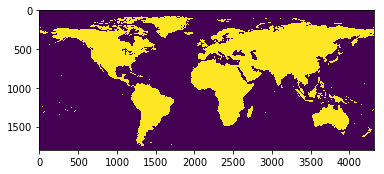

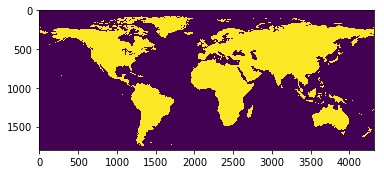

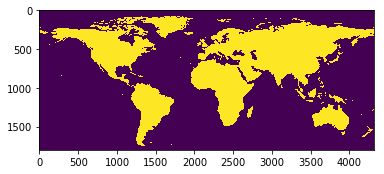

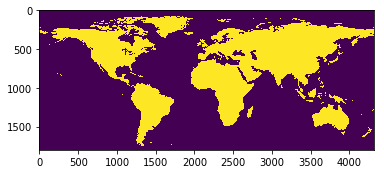

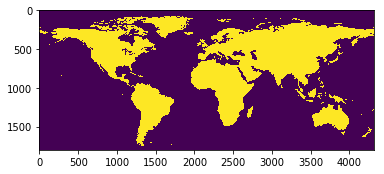

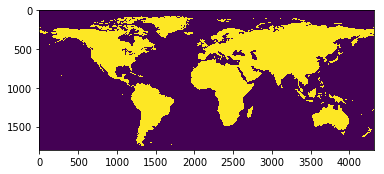

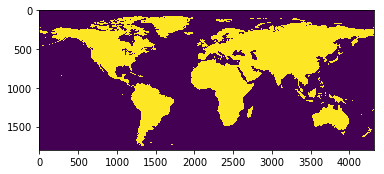

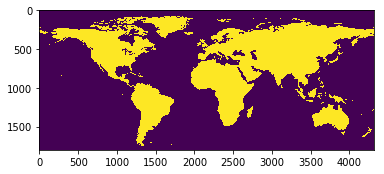

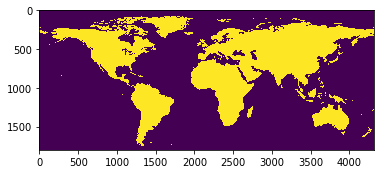

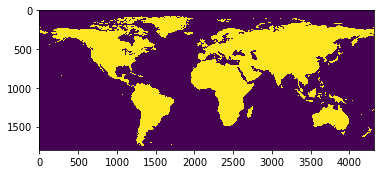

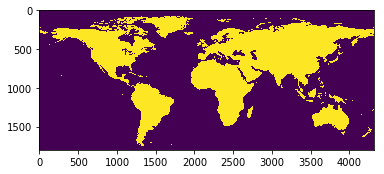

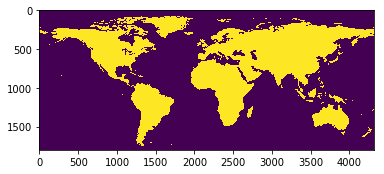

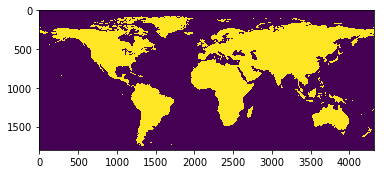

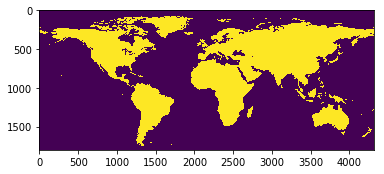

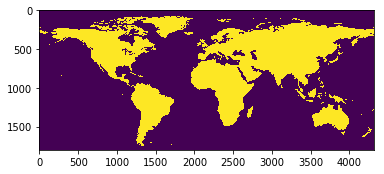

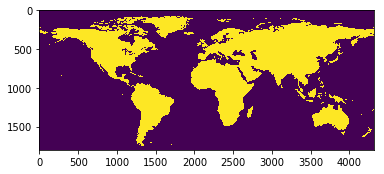

In [15]:
###create array of unique ecoregion codes and names
eco_names=df.WWF_MHTNAM.unique()
eco_codes=df.WWF_MHTNUM.unique()

####open empty landmap as source to subset values on
src=rasterio.open(file_dir+'/data/GIS/empty_land_map.tif')
profile=src.profile
band=src.read(1)

####open rasterized ecoregion map as source to extract values from
ecor=rasterio.open(file_dir+'/data/GIS/tnc/ecoregions.tif')
array=ecor.read(1)

for item in range(0,len(eco_codes)):
    new_band=band.copy()
    ecoregion=eco_names[item]
    ecoregion=ecoregion.replace(" ","_")
    ecoregion=ecoregion.replace("/","_")
    eco_subset=np.where(array==eco_codes[item])
    rows=eco_subset[0]
    cols=eco_subset[1]
    for i in range(0,len(rows)):
        new_band[rows[i],cols[i]]=1
    
    rasterio.plot.show(new_band)
    
    with rasterio.open(file_dir+'/data/GIS/tnc/ecoregion_rasters/%s_map.tif'%ecoregion,"w",**profile) as dst:
        dst.write(new_band.astype(rasterio.float32),1)

In [16]:
####stack them
list_ecoregion_files=[]
names_ecoregion=[]

##stack the rasters
for root, dirs, files in os.walk(file_dir+'/data/GIS/tnc/ecoregion_rasters'):
    for file in files:
        if file.endswith('.tif') and "time" not in file and "stacked" not in file and "UNC" not in file:
            list_ecoregion_files.append(file_dir+'/data/GIS/tnc/ecoregion_rasters/'+file)
            name=file.replace(".tif","")
            names_ecoregion.append(name)
  
#print(names_ecoregion)
es.stack(list_ecoregion_files, file_dir+'/data/GIS/tnc/ecoregion_rasters/ecoregions_stacked.tif')


(masked_array(
   data=[[[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          ...,
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38]],
 
         [[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          ...,
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
      

#### Part 6. Creating and stacking species occurrence rasters
- open empty land raster map
- identify the cell's in which occurrence records are located and set their values to 1

In [17]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/data/SQL_filtered_gbif/taxa_list.txt",header=None)
taxa.columns=["taxon"]


species_occ_dict={}

for i in taxa["taxon"]:
    taxon_data = pd.read_csv(file_dir+"/data/SQL_filtered_gbif/%s_filtered_data.csv"%i)
    #add species dataframe to dict
    species_occ_dict["%s"%i] = taxon_data  
    #check whether all species have been included and inspect dictionary
if len(species_occ_dict.keys())==len(taxa["taxon"]):
    print("All species dataframes now in dictionary")
else:
    print("Error: not all species dataframe included")

All species dataframes now in dictionary


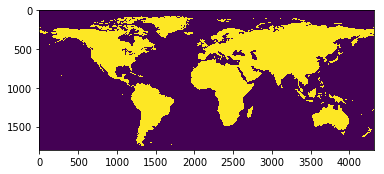

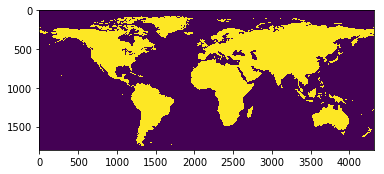

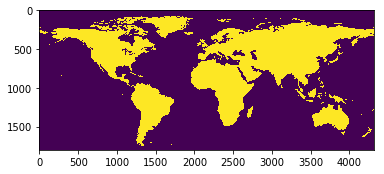

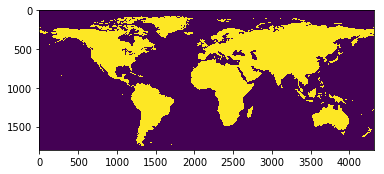

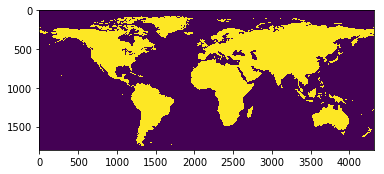

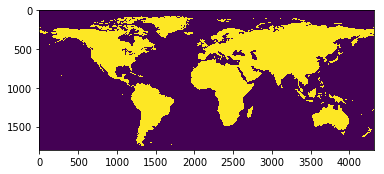

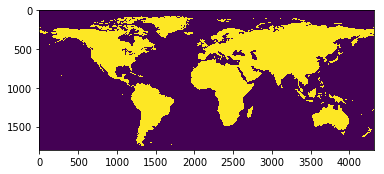

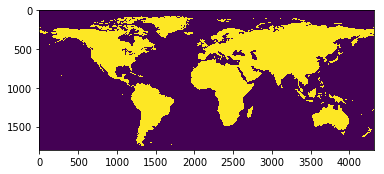

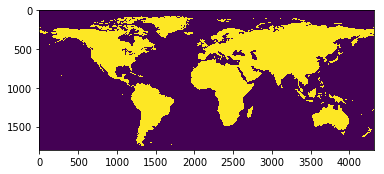

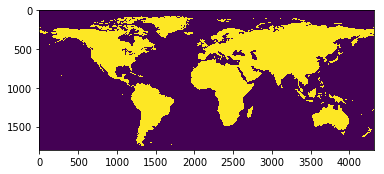

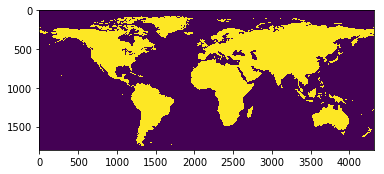

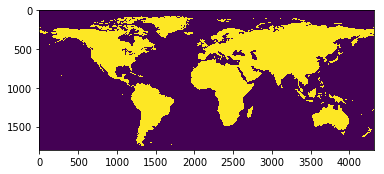

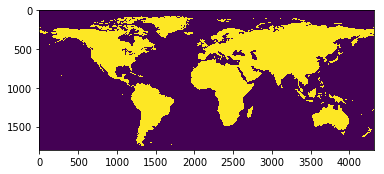

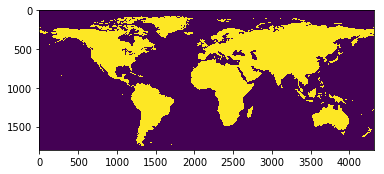

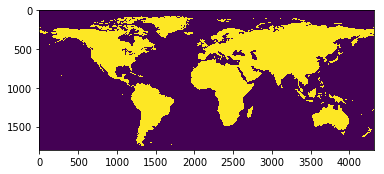

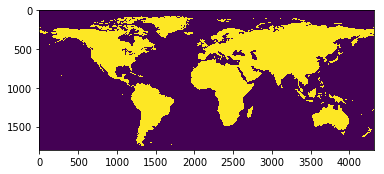

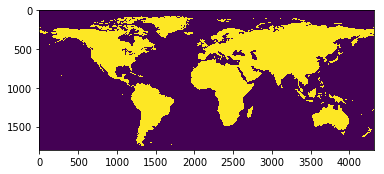

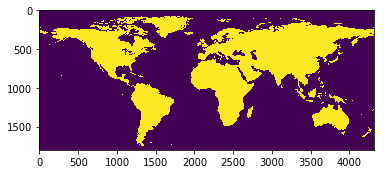

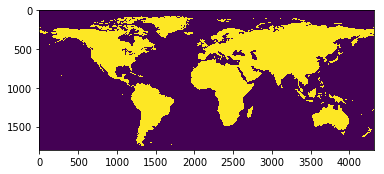

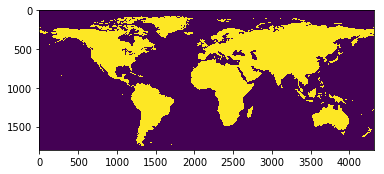

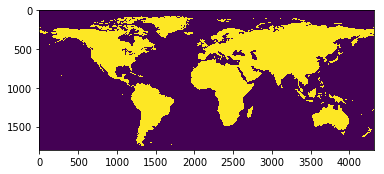

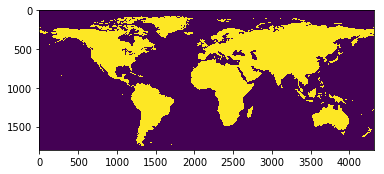

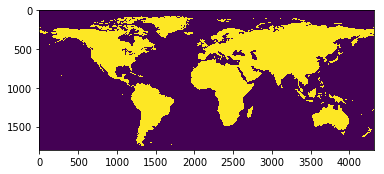

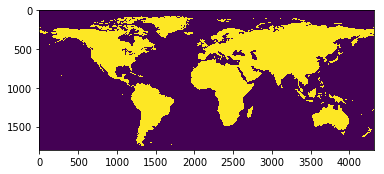

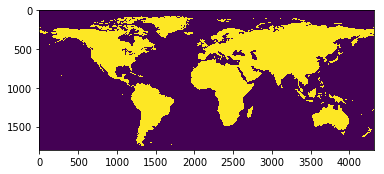

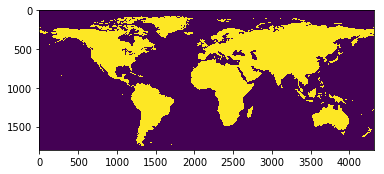

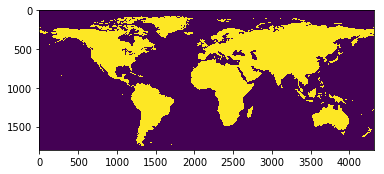

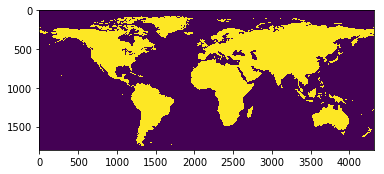

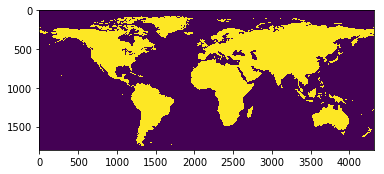

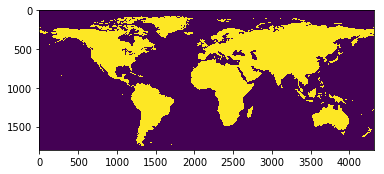

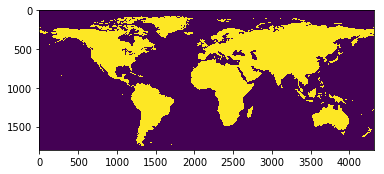

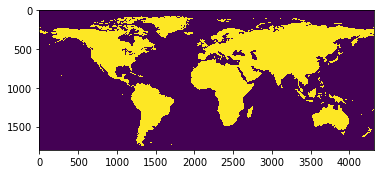

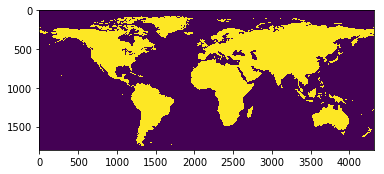

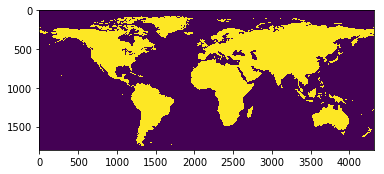

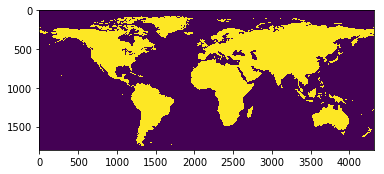

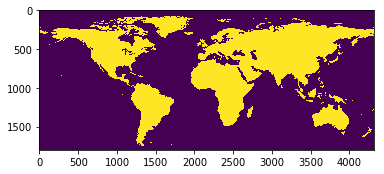

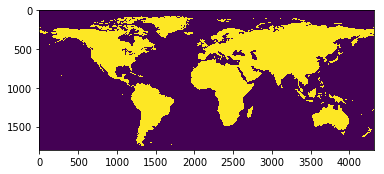

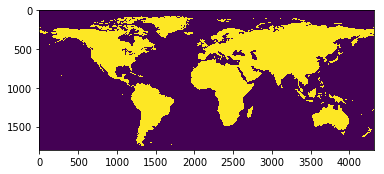

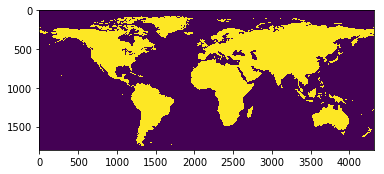

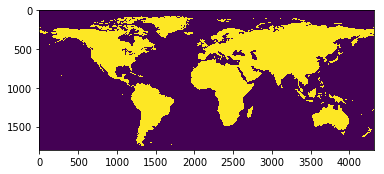

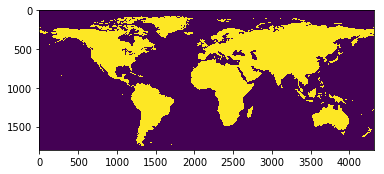

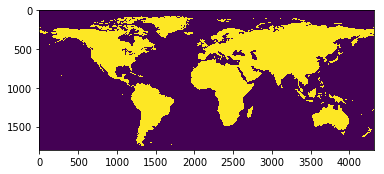

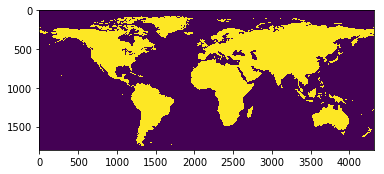

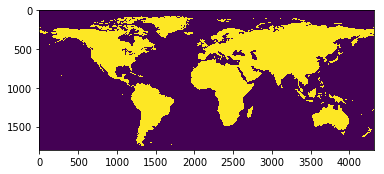

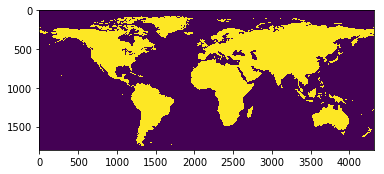

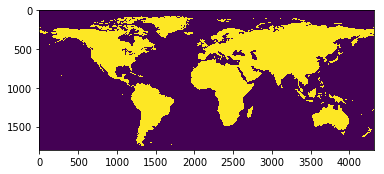

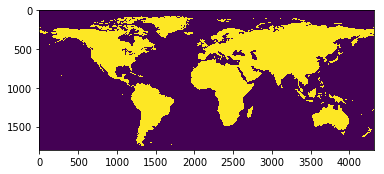

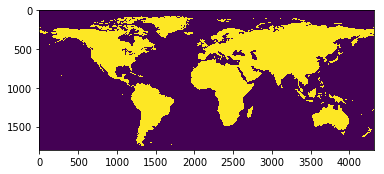

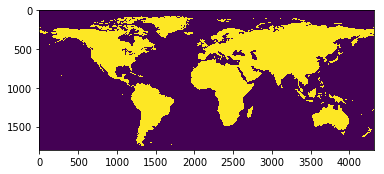

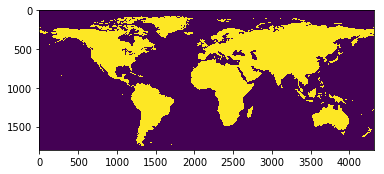

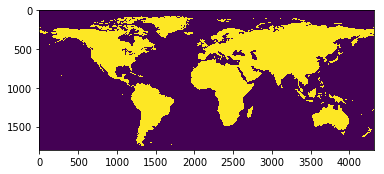

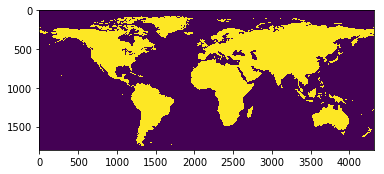

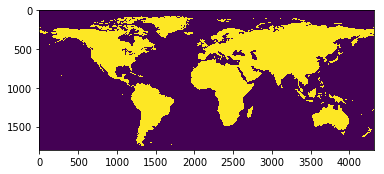

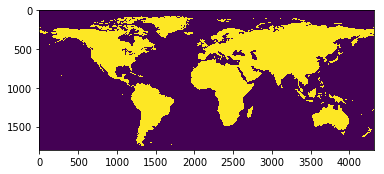

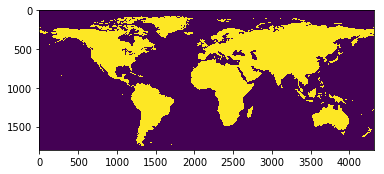

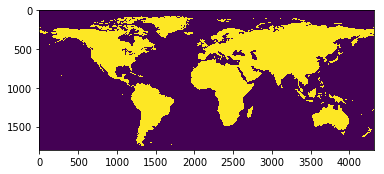

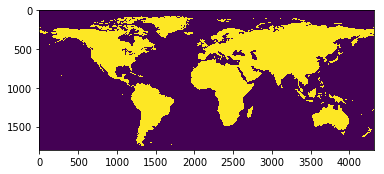

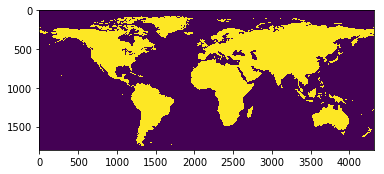

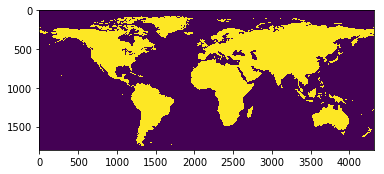

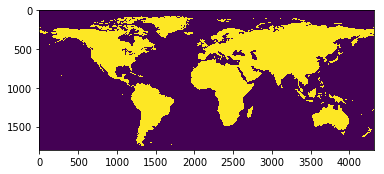

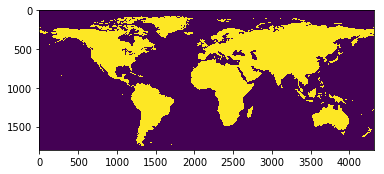

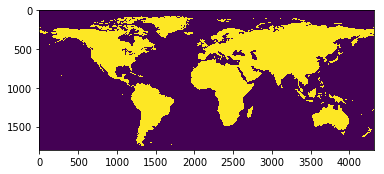

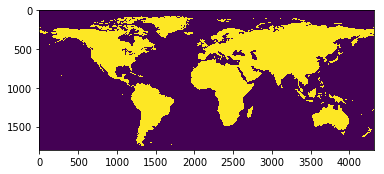

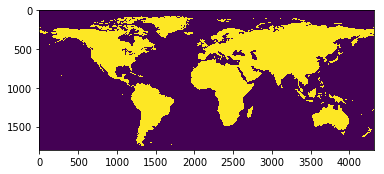

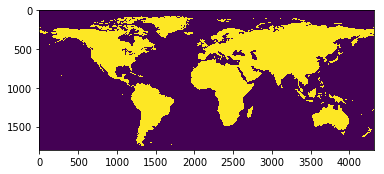

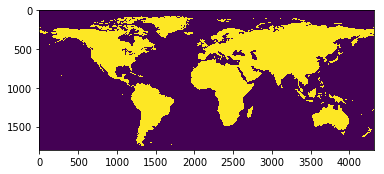

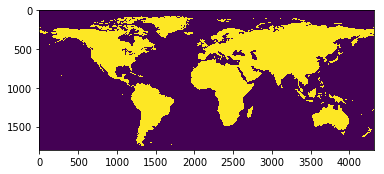

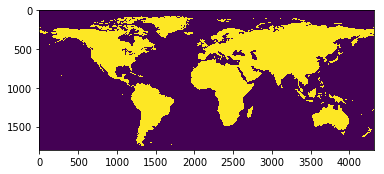

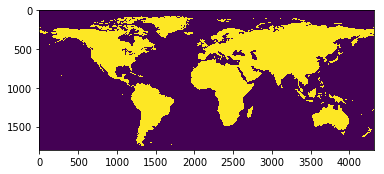

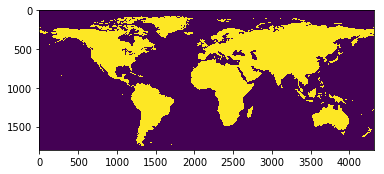

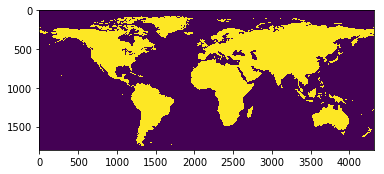

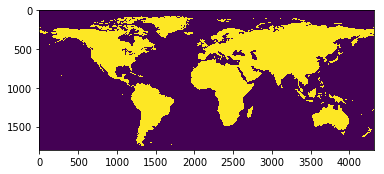

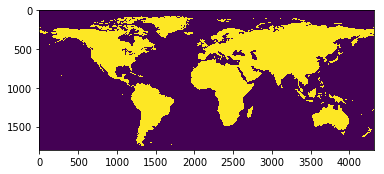

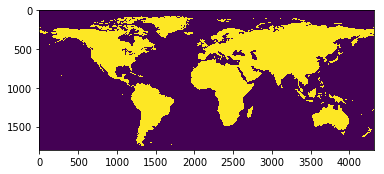

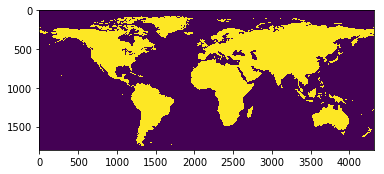

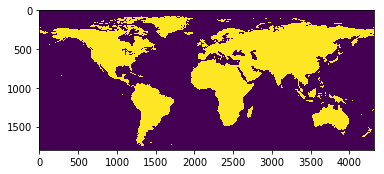

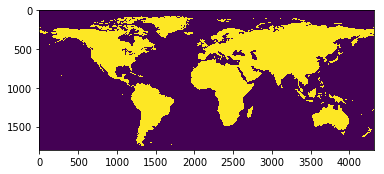

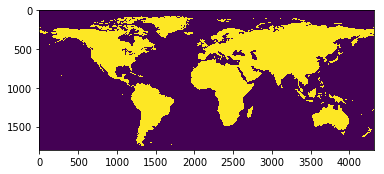

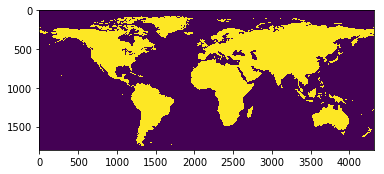

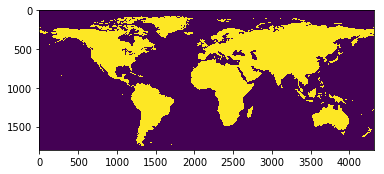

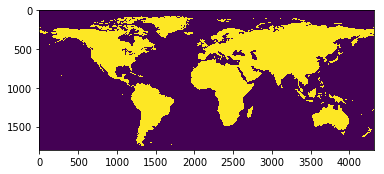

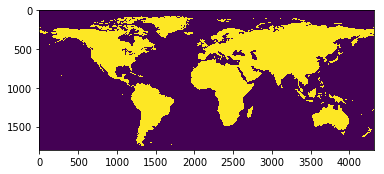

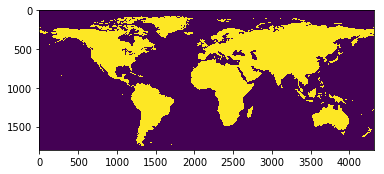

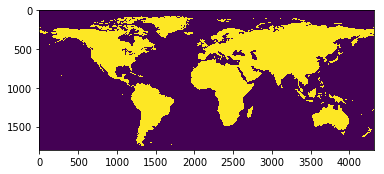

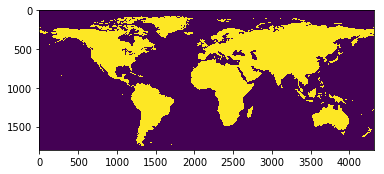

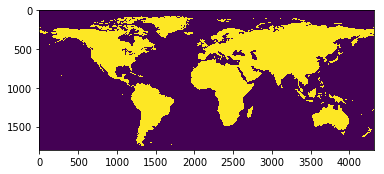

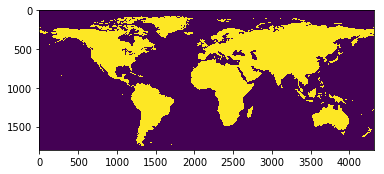

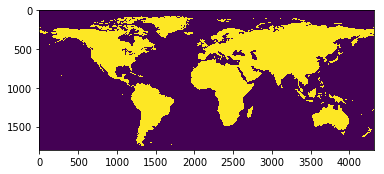

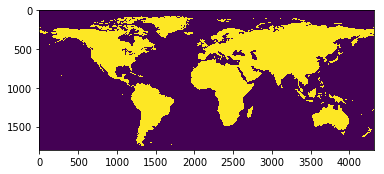

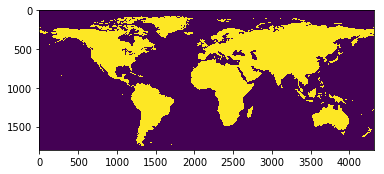

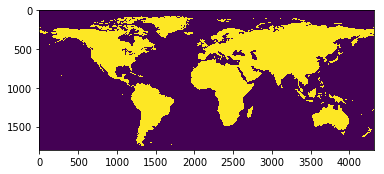

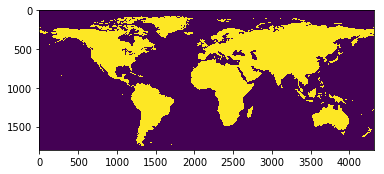

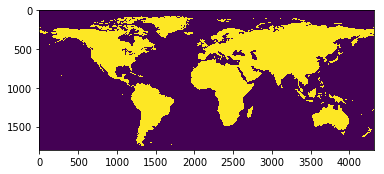

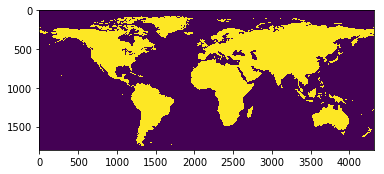

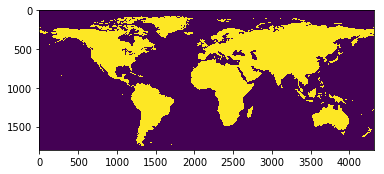

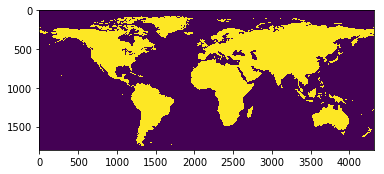

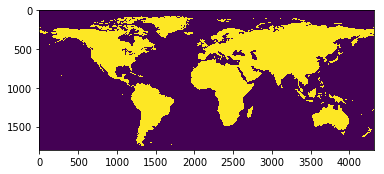

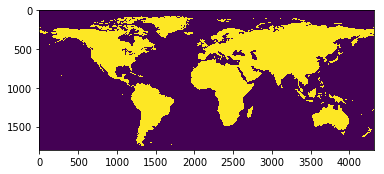

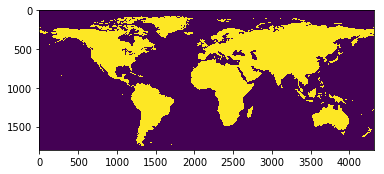

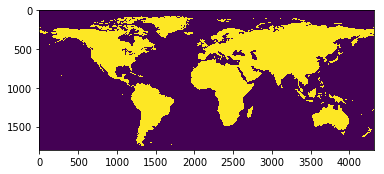

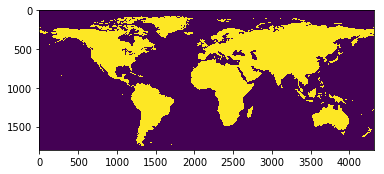

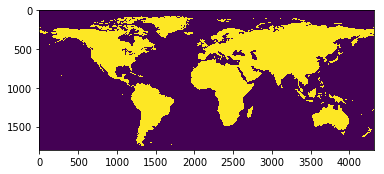

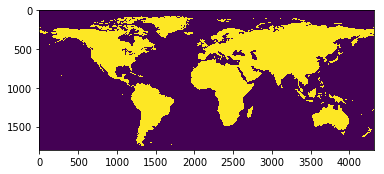

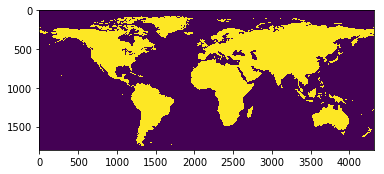

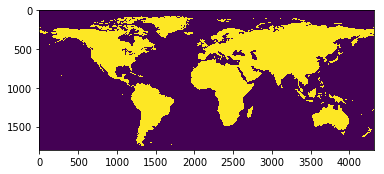

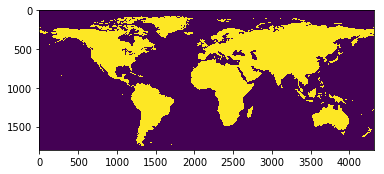

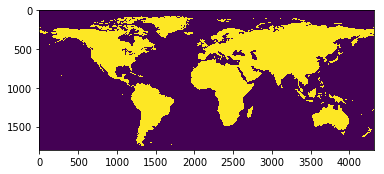

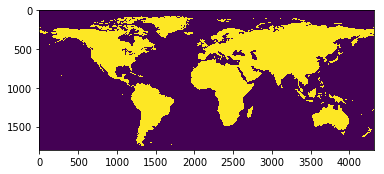

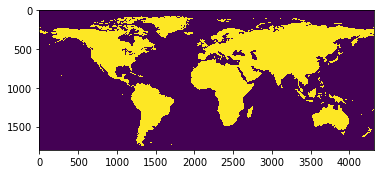

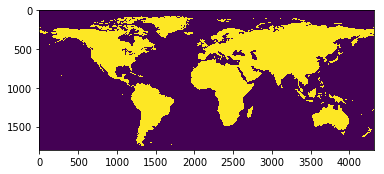

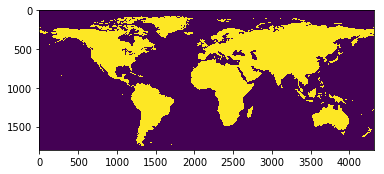

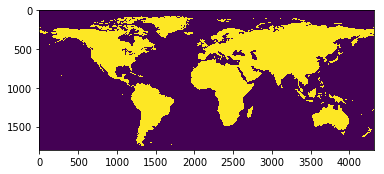

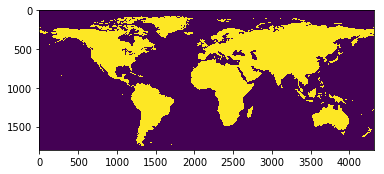

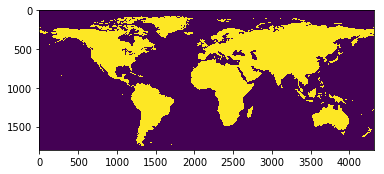

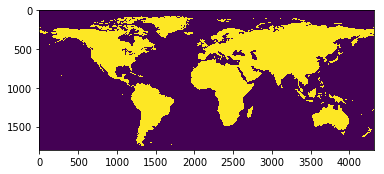

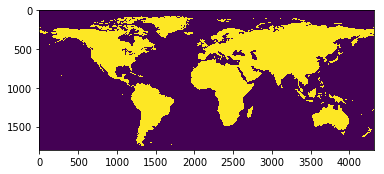

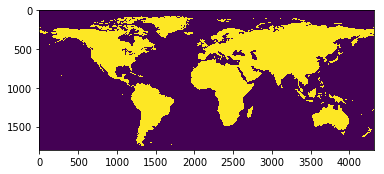

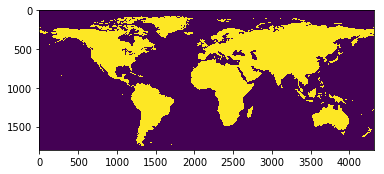

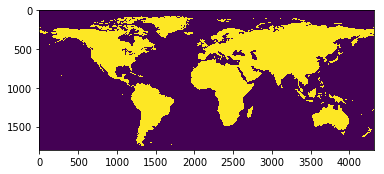

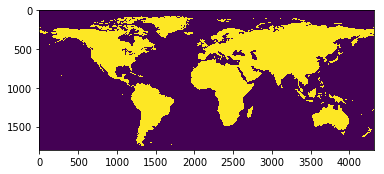

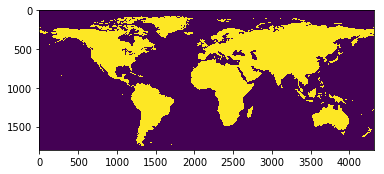

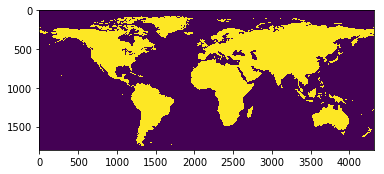

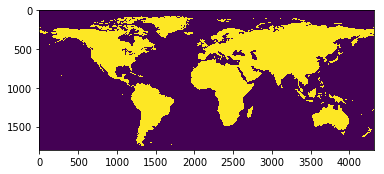

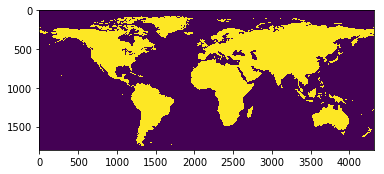

In [18]:
src=rasterio.open(file_dir+'/data/GIS/empty_land_map.tif')
band=src.read(1)

for key in species_occ_dict:
    new_band = band.copy()
    
    #lon_lat presence points
    presence_data = species_occ_dict[key]
    presence_data["present/pseudo_absent"]=1
    spec = key
    long=presence_data["decimal_longitude"]
    lati=presence_data["decimal_latitude"]
    long=pd.Series.tolist(long)
    lati=pd.Series.tolist(lati)

    #set raster cell mask values of presence locations to 100
    for i in range(0,len(presence_data)):
        row,col=src.index(long[i],lati[i])
        new_band[row,col]=1
        
    rasterio.plot.show(new_band)
    # Register GDAL format drivers and configuration options with a
    # context manager.
    #with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source


    with rasterio.open(file_dir+'/data/GIS/spec_presence/%s_presence_map.tif'%spec, 'w', **profile) as dst:
        dst.write(new_band.astype(rasterio.float32), 1)

In [19]:
####stacking them into a single raster
#species presence dataset
#create list of raster file locations and a list containing only the names of each raster
list_species_files=[]
names_species=[]

for root, dirs, files in os.walk(file_dir+"/data/GIS/spec_presence"):
    for file in files:
        if file.endswith('.tif') and "stacked" not in file:
            list_species_files.append(file_dir+"/data/GIS/spec_presence/"+file)
            name=file.replace(".tif","")
            names_species.append(name)
#print(names_species)
es.stack(list_species_files, file_dir+"/data/GIS/spec_presence/species_presence_stacked.tif")

(masked_array(
   data=[[[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          ...,
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38]],
 
         [[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          ...,
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
           -3.4e+38],
          [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38,
      

In [ ]:
print(len(list_species_files))
stacked=rasterio.open(file_dir+"/data/GIS/spec_presence/species_presence_stacked.tif")

for i in range(1,len(list_raster_locations)):
    band = stacked.read(i,masked=True)
    plt.imshow(band,interpolation="none")
    plt.show()

#### Part 7. Stack into single raster file

In [20]:
#Stack ENVIREM+BIOCLIM+HISTORIC+ECOREGION+SPECIES datasets
list_variables=[]
list_names=[]


for item in list_bioclim_files:
    list_variables.append(item)   
for item in list_envirem_files:
    list_variables.append(item)
for item in list_eco_attrib_files:
    list_variables.append(item)
for item in list_ecoregion_files:
    list_variables.append(item)
for item in list_species_files:
    list_variables.append(item)
    
     
es.stack(list_variables, file_dir+"/data/GIS/env_stacked/stacked_env_variables.tif")


for item in names_bioclim:
    list_names.append(item)   
for item in names_envirem:
    list_names.append(item)
for item in names_eco_attrib:
    list_names.append(item)
for item in names_ecoregion:
    list_names.append(item)
for item in names_species:
    list_names.append(item)
    
#save the names of the variables in order to list
myfile = open(file_dir+'/data/GIS/env_stacked/variable_list.txt', 'w+')
for item in list_names:
    myfile.write(item+"\n")
myfile.close()


(masked_array(
   data=[[[-9.999e+03, -9.999e+03, -9.999e+03, ..., -9.999e+03,
           -9.999e+03, -9.999e+03],
          [-9.999e+03, -9.999e+03, -9.999e+03, ..., -9.999e+03,
           -9.999e+03, -9.999e+03],
          [-9.999e+03, -9.999e+03, -9.999e+03, ..., -9.999e+03,
           -9.999e+03, -9.999e+03],
          ...,
          [-9.999e+03, -9.999e+03, -9.999e+03, ..., -9.999e+03,
           -9.999e+03, -9.999e+03],
          [-9.999e+03, -9.999e+03, -9.999e+03, ..., -9.999e+03,
           -9.999e+03, -9.999e+03],
          [-9.999e+03, -9.999e+03, -9.999e+03, ..., -9.999e+03,
           -9.999e+03, -9.999e+03]],
 
         [[-9.999e+03, -9.999e+03, -9.999e+03, ..., -9.999e+03,
           -9.999e+03, -9.999e+03],
          [-9.999e+03, -9.999e+03, -9.999e+03, ..., -9.999e+03,
           -9.999e+03, -9.999e+03],
          [-9.999e+03, -9.999e+03, -9.999e+03, ..., -9.999e+03,
           -9.999e+03, -9.999e+03],
          ...,
          [-9.999e+03, -9.999e+03, -9.999e+03, ..., 

5

5

5

5

5

5

5

5

5

6

6

6

6

6

6

6

6

6

6

12

17

20

26

41

38

31

26

32

32

31

31

35

34

33

31

34

34

32

19

12

11

22

20

20

11

10

25

33

36

17

14

47

38

17

42

30

50

48

51

65

53

11

32

35

25

36

35

33

23

27

25

27

36

37

27

24

27

29

28

33

32

33

34

31

34

34

36

31

36

35

37

31

33

28

27

31

35

32

33

23

30

26

28

25

26

25

32

32

31

28

29

34

36

36

33

31

32

34

40

34

23

25

29

28

33

31

28

30

32

25

28

27

31

27

34

30

32

33

36

33

35

24

26

28

30

29

24

27

29

38

36

35

35

36

34

35

29

23

31

35

34

32

31

33

29

34

33

33

27

26

24

32

29

32

28

33

33

35

34

30

34

32

38

30

27

29

In [ ]:
###create dataset to predict on

 ###Dataset of world map including all locations with data-values (to later predict presence-pseudoabsence on)
    src=rasterio.open(file_dir+'/data/GIS/env_stacked/stacked_env_variables.tif')
    array=src.read_masks(1)
    
    r = gdal.Open(file_dir+'/data/GIS/env_stacked/stacked_env_variables.tif')
    (y_index, x_index) = np.nonzero(array > 0)
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = r.GetGeoTransform()
    x_coords = x_index * x_size + upper_left_x + (x_size / 2) #add half the cell size
    y_coords = y_index * y_size + upper_left_y + (y_size / 2) #to centre the point

    lon_lat_array=np.stack((x_coords,y_coords)).T

    lon=[]
    lat=[]

    for item in lon_lat_array:
        longitude=item[0]
        latitude=item[1]
        lon.append(longitude)
        lat.append(latitude)

    taxon=["%s"%spec]*len(lon)

    data_to_pred=pd.DataFrame({"decimal_longitude":lon,"decimal_latitude":lat})
    print(len(data_to_pred), "number of points to predict")
    data_to_pred.to_csv(file_dir + "/data/GIS/world_locations_to_predict2.csv")


In [ ]:
###extract raster values at world locations to predict
data=pd.read_csv(file_dir + "/data/GIS/world_locations_to_predict.csv")
src = rasterio.open(file_dir+'/data/GIS/env_stacked/stacked_env_variables.tif')

lon = data["decimal_longitude"]
lat = data["decimal_latitude"]
lat = pd.Series.tolist(lat)
lon = pd.Series.tolist(lon)

for i in range(1, 348):
    array = src.read(i)
    band_name = list_names[i]
    data[band_name] = None
    print("processing band %s" % i)
    for j in range(0, len(data)):
        # What is the corresponding row and column in our image?
        row, col = src.index(lon[j], lat[j])  # spatial --> image coordinates
        # print(f'row,col=\t\t({row},{col})')
        # What is the value?
        value = array[row, col]
        data[band_name][j] = value
data.to_csv(file_dir + "/data/GIS/world_env_dataframe.csv")